<a href="https://colab.research.google.com/github/Bella151305/ArtProject/blob/main/Parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
import requests
from bs4 import BeautifulSoup

import time
import datetime
from datetime import datetime, timedelta
import re

import json

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

art_project_path = '/content/drive/MyDrive/Art/Art_Project'

# Unused code

In [ ]:
# Sort df by date
#df['Date'] =pd.to_datetime(df.Date)
#df.sort('Date')
#df.sort_values(by=['Date'], inplace=True, ascending=False)

# Functions

## Openings and savings
4. __open_parsing_dict()__ -> parsing_dict - Open dict with sites for parsing
5. __open_page_stat()__ -> page_stat - Open page_parsing_status.csv
6. __open_pages_counter_stat()__ -> pages_counter_stat - Open artinvest_pages_counter_stat.csv
7. __open_news_articles_data()__ -> news_articles_data - Open artinvest_news_articles_data.csv


12. __open_artinvest_long_text()__ -> long_text_df - Open artinvest_long_text.csv
13. __open_long_text_url_list_temp()__ -> parsing_list - Open json artinvest_long_text_url_list_temp
14. __save_long_text_url_list_temp(parsing_list)__ -> - Save json artinvest_long_text_url_list_temp

In [ ]:
# 4. Open dict with sites for parsing
def open_parsing_dict():
  with open(art_project_path + '/sites_for_parsing.txt', 'rb') as infile:
    parsing_dict = json.load(infile)
  return parsing_dict

# 5. Open page_parsing_status.csv
def open_page_stat():
  page_stat = pd.read_csv(art_project_path + '/page_parsing_status.csv')
  return page_stat

artinvest_s = '/artinvest_pages_counter_stat.csv'
artinvest_d = '/artinvest_news_articles_data.csv'
theartnewspaper_d = '/theartnewspaper_data_new.csv'

# 6. Open pages_counter_stat.csv
def open_pages_counter_stat(file):
  pages_counter_stat = pd.read_csv(art_project_path + file)
  return pages_counter_stat

# 7. Open news_articles_data.csv
def open_news_articles_data(file):
  news_articles_data = pd.read_csv(art_project_path + file)
  return news_articles_data

# 17. Save df to csv file
def save_df_file(df, file):
  df.to_csv(art_project_path + file, index=False)

In [ ]:
artinvest_lt = '/artinvest_long_text.csv'
theartnewspaper_lt = '/theartnewspaper_long_text.csv'

# 12. Open long_text.csv
def open_long_text(file):
  long_text_df = pd.read_csv(art_project_path + file)
  return long_text_df

# 13. Open json long_text_url_list_temp
def open_long_text_url_list_temp():
  with open(art_project_path + '/long_text_url_list_temp.txt', 'rb') as infile:
    parsing_list = json.load(infile)
  return parsing_list

# 14. Save json long_text_url_list_temp
def save_long_text_url_list_temp(parsing_list):
  with open(art_project_path + '/long_text_url_list_temp.txt', 'w') as outfile:
    json.dump(parsing_list, outfile)

## Data mining
1. __get_page(url)__ -> bs_page, page_parsing_status.csv - Collect request status


8. __get_artinvest_pages_counter_stat()__ -> - Parsing artinvest_pages_counter_stat ___and___ current artinvest_news_articles_data parsing ___and___ artinvest_long_text.csv
9. __get_artinvest_pages_curr_data(url)__ -> - Parsing current artinvest_news_articles_data
10. __get_artinvest_news_articles_archive()__ -> - Parsing artinvest_news_articles_data ARCHIVE
11. __def get_long_text()__ -> - Parsing long texts


15. __long_text_problems_fix()__ - Fixing long text problems

In [ ]:
# 1. Collect request status - saving every get result

def get_page(url):
  start_time = time.time()
  try:
    response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'}) # timeout=0.001
# Edge/97.0.1072.55
# Chrome/97.0.4692.71
    get_page_stat_new = pd.DataFrame({'page_url': [url],
                                      'status_code': [response.status_code],
                                      'encoding': [response.encoding],
                                      'raise_for_status': [response.raise_for_status()],
                                      'parsing_date': [datetime.now().date()],
                                      'parsing_time': [datetime.now().time()],
                                      'parsing_sec_speed': [time.time() - start_time]})

    bs_page = BeautifulSoup(response.text, 'html.parser')
    return bs_page

  except HTTPError: # HTTPError: 503 Server Error: Service Temporarily Unavailable for url: https://artinvestment.ru/news/artnews/
    get_page_stat_new = pd.DataFrame({'page_url': [url],
                                      'status_code': [response.status_code],
                                      'encoding': [response.encoding],
                                      'raise_for_status': [response.raise_for_status()],
                                      'parsing_date': [datetime.now().date()],
                                      'parsing_time': [datetime.now().time()],
                                      'parsing_sec_speed': [time.time() - start_time]})
    
  finally:
    get_page_stat = open_page_stat() # 5. Open page_parsing_status.csv
    get_page_stat = pd.concat([get_page_stat, get_page_stat_new])
    get_page_stat.to_csv(art_project_path + '/page_parsing_status.csv', index=False)

In [ ]:
# 8. Parsing artinvest_pages_counter_stat and current artinvest_news_articles_data parsing

# 8.1 Get links list
def get_parsing_links_list():
  sites = open_parsing_dict() # 4. Open dict with sites for parsing
  parsing_links_list = []
  for s in sites['artinvestment.ru']['news']['links']:
    parsing_links_list.append(s)
  for s in sites['artinvestment.ru']['articles']['links']:
    parsing_links_list.append(s)
  return parsing_links_list

# 8.2 Get titles list
def get_parsing_titles_list():
  sites = open_parsing_dict() # 4. Open dict with sites for parsing
  parsing_titles_list = []
  for s in sites['artinvestment.ru']['news']['titles']:
    parsing_titles_list.append(s)
  for s in sites['artinvestment.ru']['articles']['titles']:
    parsing_titles_list.append(s)
  return parsing_titles_list

# 8.3 Parsing artinvest_pages_counter_stat - saving last parsing results from the first pages
def get_artinvest_pages_counter_stat(file):
  begining_p = time.time()
  parsing_speed_p = 0
  artinvest_pages_counter_stat = open_pages_counter_stat(file) # 6. Open pages_counter_stat.csv
  artinvest_pages_counter_stat['parsing_date'] = artinvest_pages_counter_stat['parsing_date'].dropna().apply(lambda x: pd.to_datetime(x).date())
  parsing_links_list = get_parsing_links_list() # 8.1 Get links list
  parsing_titles_list = get_parsing_titles_list() # 8.2 Get titles list

  parsing_speed_p = parsing_speed_p + (time.time() - begining_p)
  for link in parsing_links_list:
    link_page = get_page(link) # 1. Collect request status
    start_time = time.time()
    try: # never problems happen only None result
      table_blocks = link_page.find_all('div', class_='pager')
    except: continue
    else: # problems can start from here
      artinvest_pages_counter_stat_new = pd.DataFrame({'page_url': [link],
                                                       'page_title': [parsing_titles_list[parsing_links_list.index(link)]],
                                                       'records_total': [int(table_blocks[0].find_all('em')[0].text)],
                                                       'pages_total': [int(table_blocks[0].find_all('em')[1].text)],
                                                       'records_max': [int(table_blocks[0].find('input').get('title').split(' ')[1])],
                                                       'records_value': [int(table_blocks[0].find('input').get('value'))],
                                                       'first_page_url': [table_blocks[0].find('a').get('href')],
                                                       'parsing_date': [datetime.now().date()],
                                                       'parsing_time': [datetime.now().time()],
                                                       'parsing_sec_speed': [time.time() - start_time]
                                                       })
      artinvest_pages_counter_stat = pd.concat([artinvest_pages_counter_stat, artinvest_pages_counter_stat_new])
      parsing_speed_p = parsing_speed_p + (time.time() - start_time)
      
      # 9. Parsing current artinvest_news_articles_data
      get_artinvest_pages_curr_data(artinvest_d, link, link_page, parsing_titles_list, parsing_links_list)

  artinvest_pages_counter_stat.drop_duplicates(subset = ['page_url', 'parsing_date'], keep = 'last', inplace = True)
  new_pages_count = artinvest_pages_counter_stat.loc[artinvest_pages_counter_stat['parsing_date']==artinvest_pages_counter_stat['parsing_date'].max()]['page_url'].count()
  
  #artinvest_pages_counter_stat.to_csv(art_project_path + file, index=False)
  save_df_file(artinvest_pages_counter_stat, file)

  return print('{} new pages have been collected\nin {} seconds\nAll pages have been collected - {}'.format(new_pages_count, parsing_speed_p, (new_pages_count==len(parsing_links_list))))

In [ ]:
# 9. Parsing current artinvest_news_articles_data - saving last parsing results from the first pages

def get_artinvest_pages_curr_data(file, page_url, page, parsing_titles, parsing_links):
  begining_a = time.time()
  parsing_speed_a = 0
  artinvest_news_articles_data = open_news_articles_data(file) # 7. Open news_articles_data.csv
  artinvest_news_articles_data['parsing_date'] = artinvest_news_articles_data['parsing_date'].dropna().apply(lambda x: pd.to_datetime(x).date())

  try: # never problems happen only None result
    start_time = time.time()
    list_advices = page.find_all('ul', class_='list advices')
  except: pass
  else: # problems can start from here
    dates_list = []
    for em in list_advices[0].find_all('em'):
      dates_list.append(em.text)
    links_list = []
    titles_list = []
    for a in list_advices[0].find_all('a'):
      if re.compile('\d+').search(str(a.get('href')))is not None:
        links_list.append(a.get('href'))
      if a.get('title') is not None:
        titles_list.append(a.get('title'))
    short_text_list = []
    for span in list_advices[0].find_all('span')[1::2]:
      short_text_list.append(span.text)

    artinvest_news_articles_data_new = pd.DataFrame({'date': dates_list,
                                                     'link': links_list,
                                                     'title': titles_list,
                                                     'short_text': short_text_list,
                                                    })
    artinvest_news_articles_data_new['page_url'] = page_url
    artinvest_news_articles_data_new['page_title'] = parsing_titles[parsing_links.index(page_url)]
    artinvest_news_articles_data_new['parsing_date'] = datetime.now().date()
    artinvest_news_articles_data_new['parsing_time'] = datetime.now().time()
    artinvest_news_articles_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

    # For parsing long texts
    artinvest_news_articles_data_new['long_text_url'] = artinvest_news_articles_data_new['page_url'] + artinvest_news_articles_data_new['link']
    long_text_url_list_new = artinvest_news_articles_data_new['long_text_url'].tolist()
    long_text_url_list = artinvest_news_articles_data['long_text_url'].tolist()
    long_text_url_list_temp = list(set(long_text_url_list_new) - set(long_text_url_list)) # only new urls - temporal list
    save_long_text_url_list_temp(long_text_url_list_temp) # 14. Save json long_text_url_list_temp

    collected_pages_a_count = artinvest_news_articles_data_new['page_url'].count()
    artinvest_news_articles_data = pd.concat([artinvest_news_articles_data, artinvest_news_articles_data_new])
    artinvest_news_articles_data.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
    parsing_speed_a = parsing_speed_a + (time.time() - begining_a)

    #artinvest_news_articles_data.to_csv(art_project_path + file, index=False)
    save_df_file(artinvest_news_articles_data, file)

    time.sleep(5) # time for renewing json artinvest_long_text_url_list_temp
    get_long_text(artinvest_lt) # 11. Parsing long texts

    return print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, parsing_speed_a))

In [ ]:
# 11. Parsing long texts - saving only new results from the first pages
    
def get_long_text(file):
  begining_t = time.time()
  parsing_speed_t = 0
  artinvest_long_text_df = open_long_text(file) # 12. Open long_text.csv
  long_text_url_list = open_long_text_url_list_temp() # 13. Open json long_text_url_list_temp
  
  long_text_list = []
  sourses_list = []
  parsing_speed_list = []

  for url in long_text_url_list:
    text_page = get_page(url) # 1. Collect request status
    start_time = time.time()

    try:
      text_block = text_page.find('div', class_='block content-data article-content')
      text_all = text_block.find_all('p')
      text_list = []
      for p in text_all:
        text_list.append(p.text)
      long_text_list.append(text_list)
    except: 
      text_list = []
      long_text_list.append(text_list)
    try:
      sourse_all = text_block.find('p', class_='mat2left').find_all('a')
      sourses = []
      for a in sourse_all:
        sourses.append(a.get('href'))
      sourses_list.append(sourses)
    except: 
      sourses = []
      sourses_list.append(sourses)
    finally:
      parsing_speed_list.append(time.time() - start_time)

  artinvest_long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list,
                                             'long_text': long_text_list,
                                             'sourses': sourses_list,
                                             'parsing_sec_speed_2': parsing_speed_list # for long_text collection without getting page
                                            })
  
  collected_pages_t_count = artinvest_long_text_df_new['long_text_url'].count()
  artinvest_long_text_df = pd.concat([artinvest_long_text_df, artinvest_long_text_df_new])
  artinvest_long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
  parsing_speed_t = parsing_speed_t + (time.time() - begining_t)

  #artinvest_long_text_df.to_csv(art_project_path + file, index=False)
  save_df_file(artinvest_long_text_df, file)

  return print('{} text pages have been collected\nin {} seconds\nAll text pages have been collected - {}'.format(collected_pages_t_count, parsing_speed_t, collected_pages_t_count==len(long_text_url_list)))

# 11.1 Parsing problematic long texts

def get_long_text_problems(file, long_text_url_list):
  begining_t = time.time()
  parsing_speed_t = 0
  artinvest_long_text_df = open_long_text(file) # 12. Open long_text.csv
  #long_text_url_list = open_long_text_url_list_temp() # 13. Open json artinvest_long_text_url_list_temp
  
  long_text_list = []
  sourses_list = []
  parsing_speed_list = []

  for url in long_text_url_list:
    text_page = get_page(url) # 1. Collect request status
    start_time = time.time()

    try:
      text_block = text_page.find('div', class_='block content-data article-content')
      text_all = text_block.find_all('p')
      text_list = []
      for p in text_all:
        text_list.append(p.text)
      long_text_list.append(text_list)
    except: 
      text_list = []
      long_text_list.append(text_list)
    try:
      sourse_all = text_block.find('p', class_='mat2left').find_all('a')
      sourses = []
      for a in sourse_all:
        sourses.append(a.get('href'))
      sourses_list.append(sourses)
    except: 
      sourses = []
      sourses_list.append(sourses)
    finally:
      parsing_speed_list.append(time.time() - start_time)

  artinvest_long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list,
                                             'long_text': long_text_list,
                                             'sourses': sourses_list,
                                             'parsing_sec_speed_2': parsing_speed_list # for long_text collection without getting page
                                            })

  collected_pages_t_count = artinvest_long_text_df_new['long_text_url'].count()
  artinvest_long_text_df = pd.concat([artinvest_long_text_df, artinvest_long_text_df_new])
  artinvest_long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
  parsing_speed_t = parsing_speed_t + (time.time() - begining_t)

  #artinvest_long_text_df.to_csv(art_project_path + file, index=False)
  save_df_file(artinvest_long_text_df, file)

  return print('{} text pages have been collected\nin {} seconds\nAll pages have been collected - {}'.format(collected_pages_t_count, parsing_speed_t, collected_pages_t_count==len(long_text_url_list)))

In [ ]:
# 10. Parsing artinvest_news_articles_data ARCHIVE

def get_artinvest_news_articles_archive(file, p_url):
  artinvest_pages_counter_stat_arch = open_pages_counter_stat(file) # 6. Open pages_counter_stat.csv
  artinvest_pages_counter_stat_arch['parsing_date'] = artinvest_pages_counter_stat_arch['parsing_date'].dropna().apply(lambda x: pd.to_datetime(x).date())
  artinvest_pages_counter_stat_arch = artinvest_pages_counter_stat_arch.loc[(artinvest_pages_counter_stat_arch['page_url']==p_url)&(artinvest_pages_counter_stat_arch['parsing_date']==artinvest_pages_counter_stat_arch['parsing_date'].max())]

  # For parsing current artinvest_news_articles_data
  pars_links_list = artinvest_pages_counter_stat_arch['page_url'].tolist()
  pars_titles_list = artinvest_pages_counter_stat_arch['page_title'].tolist()
  # For next_page_url_list
  first_page_url_list = artinvest_pages_counter_stat_arch['first_page_url'].tolist()
  pages_total_list = artinvest_pages_counter_stat_arch['pages_total'].tolist()

  next_page_url_list = []
  for url in first_page_url_list:
    pages_total = pages_total_list[first_page_url_list.index(url)]
    url_part_1 = url.split('=')[0]
    url_part_2 = url.split('=')[1].split('&')[1]
    url_part_3 = url.split('=')[2]

    for p in range(2,pages_total+1):
      next_page_url = url_part_1 + '=' + str(p) + '&' + url_part_2 + '=' + url_part_3
      next_page_url_list.append(next_page_url)

  for p_url in next_page_url_list:
    page = get_page(p_url) # 1. Collect request status
    # 9. Parsing current artinvest_news_articles_data
    get_artinvest_pages_curr_data(artinvest_d, p_url.split('=')[0][:-5], page, pars_titles_list, pars_links_list)

In [ ]:
# 15. Fixing long text problems
def long_text_problems_fix():
  cheking_long_text_list = []
  for url in artinvest_news_articles_w_text.loc[artinvest_news_articles_w_text['long_text'].isna()==True]['long_text_url']:
    cheking_long_text_list.append(url)

  cheking_date_list = []
  for date in artinvest_news_articles_w_text.loc[artinvest_news_articles_w_text['long_text'].isna()==True]['date']:
    cheking_date_list.append(date)

  delta = len(cheking_date_list)-len(cheking_long_text_list)

  if delta == 0:
    result = 'All long texts were found'
  else:
    long_text_url_visited = len(page_statistic.loc[page_statistic['page_url'].isin(cheking_long_text_list)]['page_url'].tolist())
    long_text_url_list = cheking_long_text_list
    get_long_text_problems(artinvest_lt, long_text_url_list) # 11.1 Parsing problematic long texts
    result = 'News dates and long texts delta is - {}\nCount of sites were visited - {}'.format(delta, long_text_url_visited)
  
  return print(result)

## Graphics
16. get_graphics() -> - Drawing graphics

In [ ]:
# 16. Drawing graphics
def get_graphics():
  # 16.1 Checking responses status
  print('Checking responses status & Parsing date')
  print('')
  new_stat = page_statistic.loc[page_statistic['parsing_date'] >= (page_statistic['parsing_date'].max() + timedelta(days = -7))]
  
  fig, axes = plt.subplots(1, 2, figsize=(12,4))
  
  axes[0].hist(page_statistic['status_code'])
  axes[0].set_title('Status code')
  axes[0].set_ylabel('Count')
  #axes[0].set_xticklabels(page_statistic['status_code'].unique(), rotation = 45)
  
  axes[1].hist(new_stat['parsing_date'])
  axes[1].set_title('Parsing date counts')
  axes[1].set_ylabel('Count')
  axes[1].set_xticklabels(new_stat['parsing_date'].unique(), rotation = 45)

  plt.show()

  # 16.2 Collecting Pages counter mining avarege speed
  print('')
  print('Collecting Pages counter mining avarege speed')
  print('')
  grouped_page_stat = page_statistic.groupby(['parsing_date', 'page_url'])['parsing_sec_speed'].agg(['mean']).reset_index()

  pages_counter_mining = pd.merge(artinvest_pages_counter_stat, grouped_page_stat, on=['parsing_date', 'page_url'], how='left')
  pages_counter_mining.columns = ['page_url', 'page_title', 'records_total', 'pages_total', 'records_max', 'records_value',
                                  'first_page_url', 'parsing_date', 'parsing_time', 'parsing_counter_speed', 'parsing_page_speed']
  pages_counter_mining['parsing_speed_total'] = pages_counter_mining['parsing_counter_speed'] + pages_counter_mining['parsing_page_speed']

  pages_counter_mining = pages_counter_mining.loc[pages_counter_mining['parsing_date'] >= (pages_counter_mining['parsing_date'].max() + timedelta(days = -7))]
  pages_counter_mining = pages_counter_mining.groupby(['parsing_date'])[['parsing_speed_total', 'parsing_page_speed', 'parsing_counter_speed']].mean().reset_index()

  fig, axes = plt.subplots(1, 3, figsize=(12,4))
  axes[0].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_speed_total'], color='red')
  axes[0].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[0].set_title('Total avg speed in seconds')

  axes[1].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_page_speed'], color='blue')
  axes[1].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[1].set_title('Page avg speed in seconds')

  axes[2].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_counter_speed'], color='green')
  axes[2].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[2].set_title('Counter avg speed in seconds')

  plt.show()

  # 16.3 Collecting Data mining avarege speed
  print('')
  print('Collecting Data mining avarege speed')
  print('')
  grouped_news_articl_stat = artinvest_news_articles_w_text.groupby(['parsing_date', 'page_url'])['parsing_sec_speed', 'parsing_sec_speed_2'].agg(['mean']).reset_index()
  grouped_news_articl_stat.columns = ['parsing_date',	'page_url',	'parsing_data_speed',	'parsing_text_speed']

  pages_data_mining = pd.merge(grouped_news_articl_stat, grouped_page_stat, on=['parsing_date', 'page_url'], how='left')
  pages_data_mining.columns = ['parsing_date', 'page_url', 'parsing_data_speed', 'parsing_text_speed', 'parsing_page_speed']

  pages_data_mining['parsing_speed_total'] = pages_data_mining['parsing_data_speed'] + pages_data_mining['parsing_text_speed'] + pages_data_mining['parsing_page_speed']

  pages_data_mining = pages_data_mining.loc[pages_data_mining['parsing_date'] >= (pages_data_mining['parsing_date'].max() + timedelta(days = -7))]
  pages_data_mining = pages_data_mining.groupby(['parsing_date'])[['parsing_data_speed', 'parsing_text_speed', 'parsing_page_speed', 'parsing_speed_total']].mean().reset_index()

  fig, axes = plt.subplots(1, 4, figsize=(12,4))
  axes[0].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_speed_total'], color='red')
  axes[0].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[0].set_title('Total avg speed in seconds')

  axes[1].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_page_speed'], color='blue')
  axes[1].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[1].set_title('Page avg speed in seconds')

  axes[2].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_data_speed'], color='green')
  axes[2].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[2].set_title('Data avg speed in seconds')

  axes[3].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_text_speed'], color='orange')
  axes[3].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[3].set_title('Text avg speed in seconds')

  plt.show()

  # 16.4 Articles counting
  print('')
  print('Articles counting')
  print('')
  # today for previouse day or for some days ago
  new_data = artinvest_news_articles_w_text.loc[artinvest_news_articles_w_text['date']>=artinvest_news_articles_w_text['parsing_date'].unique()[-2]]

  fig = plt.figure()
  axes = fig.add_axes([0,0,1,1])
  axes.hist(new_data['page_title'])
  axes.set_title('New articles')
  axes.set_ylabel('Count')
  axes.set_xticklabels(new_data['page_title'].unique(), rotation = 20)

  plt.show()

  print('')
  print('New articles titles:')
  print('')
  for t in new_data['title']:
    print(t)

# artinvestment.ru

- fix labels in some graphics
- collected info only from news and articles
- fix problem with dates

## Sites parsing

In [ ]:
# Parsing artinvest_pages_counter_stat and current artinvest_news_articles_data parsing
start_t = time.time()
get_artinvest_pages_counter_stat(artinvest_s) # 8.3 Parsing artinvest_pages_counter_stat
finish_t = time.time() - start_t
print('{} seconds have passed'.format(finish_t))

2 text pages have been collected
in 5.401077032089233 seconds
All text pages have been collected - True
30 articles have been collected
in 2.0055413246154785 seconds
0 text pages have been collected
in 1.219351053237915 seconds
All text pages have been collected - True
30 articles have been collected
in 1.3823156356811523 seconds
0 text pages have been collected
in 1.1216700077056885 seconds
All text pages have been collected - True
30 articles have been collected
in 1.368898630142212 seconds
0 text pages have been collected
in 1.3655543327331543 seconds
All text pages have been collected - True
30 articles have been collected
in 1.4075546264648438 seconds
1 text pages have been collected
in 2.89560866355896 seconds
All text pages have been collected - True
30 articles have been collected
in 1.369131088256836 seconds
0 text pages have been collected
in 1.1194136142730713 seconds
All text pages have been collected - True
30 articles have been collected
in 1.3613815307617188 seconds
0 te

In [ ]:
# !!! do it just once
# Parsing artinvest_news_articles_data ARCHIVE

confirmation = input('Confirm the archive parsing (y/n)')
if confirmation == 'y':
  print('Parsing is started')
  get_artinvest_news_articles_archive(artinvest_s) # 10. Parsing artinvest_news_articles_data ARCHIVE
else:
  print('Nothing has happened')

# done !!!

Confirm the archive parsing (y/n)n
Nothing has happened


## Checking

In [ ]:
# Opening
artinvest_pages_counter_stat = open_pages_counter_stat(artinvest_s) # 6. Open pages_counter_stat.csv
artinvest_news_articles_data = open_news_articles_data(artinvest_d) # 7. Open news_articles_data.csv
artinvest_long_text_df = open_long_text(artinvest_lt) # 12. Open long_text.csv
page_statistic = open_page_stat() # 5. Open page_parsing_status.csv

# Dates
artinvest_pages_counter_stat['parsing_date'] = artinvest_pages_counter_stat['parsing_date'].dropna().apply(lambda x: pd.to_datetime(x).date())
artinvest_news_articles_data['parsing_date'] = artinvest_news_articles_data['parsing_date'].dropna().apply(lambda x: pd.to_datetime(x).date())
artinvest_news_articles_data['date'] = artinvest_news_articles_data['date'].dropna().apply(lambda x: pd.to_datetime(x).date())
page_statistic['parsing_date'] = page_statistic['parsing_date'].dropna().apply(lambda x: pd.to_datetime(x).date())

# Checking long texts
artinvest_news_articles_w_text = artinvest_news_articles_data.merge(artinvest_long_text_df, on='long_text_url', how='left')
long_text_problems_fix() # 15. Fixing long text problems

All long texts were found


In [ ]:
# Checking collected lines

pages_counter = artinvest_pages_counter_stat.loc[artinvest_pages_counter_stat['parsing_date']==artinvest_pages_counter_stat['parsing_date'].max()][['page_url', 'page_title', 'records_total']]
data_counter = artinvest_news_articles_data.groupby(['page_title']).size().to_frame(name = 'count').reset_index()
combo = pages_counter.merge(data_counter, on='page_title', how='outer')
combo['delta'] = combo['records_total'] - combo['count']

problem_archive_pages = combo.loc[combo['delta']!=0]['page_url'].tolist()
if len(problem_archive_pages)==0:
  print('Records delta has not found')
else:
  display(combo.loc[combo['page_url'].isin(problem_archive_pages)])

Records delta has not found


In [ ]:
# Parsing artinvest_news_articles_data ARCHIVE again
# !!!
confirmation = input('Confirm the archive parsing (y/n)')
if confirmation == 'y':
  print('Parsing is started')
  get_artinvest_news_articles_archive(problem_archive_pages[0]) # 10. Parsing artinvest_news_articles_data ARCHIVE
else:
  print('Nothing has happened')

Confirm the archive parsing (y/n)n
Nothing has happened


Checking responses status & Parsing date



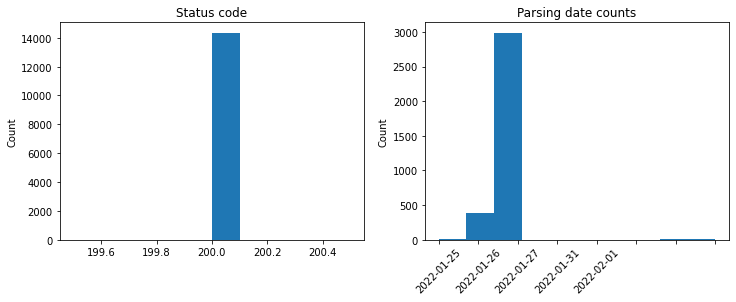

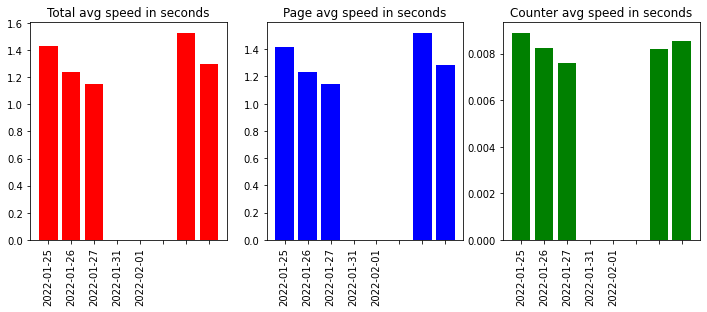

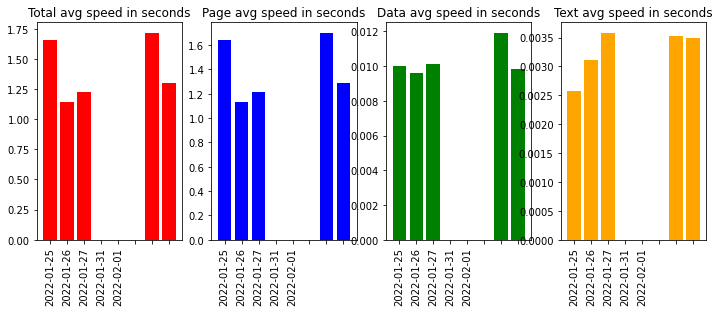


Articles counting



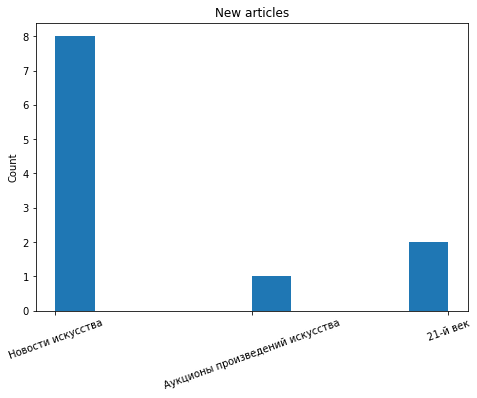


New articles titles:

Галерея Бельведер выпустит токены «Поцелуя» Климта ко Дню Святого Валентина
В Нью-Йорке выставили редкий рисунок Дюрера
Sotheby’s выставил на продажу картину Рене Магритта «Империя света»
Боттичелли, Ван Дейк и другие искусствоведческие находки последнего времени
Коллекция Майкла Кейна будет распродана на Bonhams
Топ-лотами предстоящего аукциона современного искусства Phillips станут портреты работы Уорхола и Бэнкси
Рейксмузеум оцифровал «Ночной дозор» Рембрандта
NFT-платформа OpenSea привлекла $300 млн венчурного капитала и теперь оценивается в $13,3 млрд
Открыты 412-е торги AI Аукциона
Открыт 101-й аукцион «21-й век. Современное российское искусство»
Открыт 98-й аукцион «21-й век. Современное российское искусство»


In [ ]:
get_graphics()

In [ ]:
artinvest_pages_counter_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   page_url           53 non-null     object 
 1   page_title         53 non-null     object 
 2   records_total      53 non-null     int64  
 3   pages_total        53 non-null     int64  
 4   records_max        53 non-null     int64  
 5   records_value      53 non-null     int64  
 6   first_page_url     53 non-null     object 
 7   parsing_date       53 non-null     object 
 8   parsing_time       53 non-null     object 
 9   parsing_sec_speed  53 non-null     float64
dtypes: float64(1), int64(4), object(5)
memory usage: 4.3+ KB


In [ ]:
artinvest_news_articles_w_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10783 entries, 0 to 10782
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 10783 non-null  object 
 1   link                 10783 non-null  object 
 2   title                10783 non-null  object 
 3   short_text           10783 non-null  object 
 4   page_url             10783 non-null  object 
 5   page_title           10783 non-null  object 
 6   parsing_date         10783 non-null  object 
 7   parsing_time         10783 non-null  object 
 8   parsing_sec_speed    10783 non-null  float64
 9   long_text_url        10783 non-null  object 
 10  long_text            10783 non-null  object 
 11  sourses              10783 non-null  object 
 12  parsing_sec_speed_2  10783 non-null  float64
dtypes: float64(2), object(11)
memory usage: 1.5+ MB


In [ ]:
artinvest_long_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10783 entries, 0 to 10782
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   long_text_url        10783 non-null  object 
 1   long_text            10783 non-null  object 
 2   sourses              10783 non-null  object 
 3   parsing_sec_speed_2  10783 non-null  float64
dtypes: float64(1), object(3)
memory usage: 337.1+ KB


In [ ]:
#page_statistic = page_statistic[0:0]
page_statistic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11943 entries, 0 to 11942
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   page_url           11943 non-null  object 
 1   status_code        11943 non-null  int64  
 2   encoding           11943 non-null  object 
 3   raise_for_status   0 non-null      float64
 4   parsing_date       11943 non-null  object 
 5   parsing_time       11943 non-null  object 
 6   parsing_sec_speed  11943 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 653.3+ KB


In [ ]:
#artinvest_pages_counter_stat.to_csv(art_project_path + '/artinvest_pages_counter_stat.csv', index=False)

In [ ]:
#artinvest_news_articles_data.to_csv(art_project_path + '/artinvest_news_articles_data.csv', index=False)

In [ ]:
#artinvest_long_text_df.to_csv(art_project_path + '/artinvest_long_text.csv', index=False)

In [ ]:
#page_statistic.to_csv(art_project_path + '/page_parsing_status.csv', index=False)

In [ ]:
artinvest_long_text_df = open_artinvest_long_text()

In [ ]:
artinvest_long_text_df['long_text'][0]

"['Вчера, 7 декабря 2021,  аукционный дом Sotheby’s провел в своем лондонском офисе  торги одного лота — римской мраморной скульптуры богини Афродиты, известной как  Афродита Гамильтона (по имени одного из владельцев). Лот был выставлен с  оценкой £2–3 млн, но в ходе 20-минутной аукционной борьбы между пятью  претендентами скульптура превысила эстимейт как минимум в девять раз. Новому  владельцу — некому азиатскому клиенту Sotheby’s,  чьи ставки называла менеджер по работе с клиентами Николь Чинг — Афродита  Гамильтона досталась за £18,6 млн ($24,6 млн) с учетом комиссии аукционного  дома. Это новый аукционный рекорд для античной мраморной скульптуры.', 'Афродита Гамильтона  была продана дороже, чем античный мраморный бюст Антиноя II в. н. э., за  который в 2010 году заплатили $23,8 млн. Впрочем результатам Афродиты и Антиноя  не удастся потягаться с абсолютным рекордом для древней скульптуры вообще: с  2007 года он безраздельно принадлежит миниатюрной 8-сантиметровой вавилонской  стат

In [ ]:
artinvest_long_text_df['sourses'][0]

"['https://www.artnews.com/art-news/market/hamilton-aphrodite-auction-record-1234612590/', 'https://observer.com/2021/11/a-scotsmans-beloved-hamilton-aphrodite-is-going-up-for-auction-at-sothebys/']"

In [ ]:
print(artinvest_news_articles_data['page_url'][0])
print(artinvest_news_articles_data['long_text_url'][0])

https://artinvestment.ru/news/artnews/
https://artinvestment.ru/news/artnews/20211208_Aphrodite_sale.html


In [ ]:
new_data = artinvest_news_articles_w_text.loc[artinvest_news_articles_w_text['date'] >= artinvest_news_articles_w_text['parsing_date'].unique()[-2]]
new_data

,date,link,title,short_text,page_url,page_title,parsing_date,parsing_time,parsing_sec_speed,long_text_url,long_text,sourses,parsing_sec_speed_2
12763,2022-01-31,20220131_kiss_by_klimt.html,Галерея Бельведер выпустит токены «Поцелуя» Кл...,Картина будет поделена на 10 000 уникальных NF...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-01,08:25:52.733521,0.009989,https://artinvestment.ru/news/artnews/20220131...,['Венская галерея Бельведер объявила о планах ...,['https://artdaily.com/news/143417/NFTs-of--Th...,0.002469
12764,2022-01-31,20220131_durer.html,В Нью-Йорке выставили редкий рисунок Дюрера,Цена работы может составлять порядка $10 млн,https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-01,08:25:52.733521,0.009989,https://artinvestment.ru/news/artnews/20220131...,['В Нью-Йорке во время ежегодных зимних аукци...,['https://news.artnet.com/market/master-drawin...,0.003227
12785,2022-12-01,20220112_magritte.html,Sotheby’s выставил на продажу картину Рене Маг...,Оценочная стоимость написанного в 1961 году по...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-01,08:25:52.733521,0.009989,https://artinvestment.ru/news/artnews/20220112...,"['Аукционный дом Sotheby’s объявил о том, что...",['https://news.artnet.com/market/a-moody-rene-...,0.002426
12786,2022-12-01,20220112_find.html,"Боттичелли, Ван Дейк и другие искусствоведческ...",Под красочным слоем картины Боттичелли обнаруж...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-01,08:25:52.733521,0.009989,https://artinvestment.ru/news/artnews/20220112...,['В конце января на Sotheby’s появится картин...,['https://edition.cnn.com/style/article/bottic...,0.002470
12787,2022-11-01,20220111_Bonhams.html,Коллекция Майкла Кейна будет распродана на Bon...,"Один из топ-лотов — картина Марка Шагала, оцен...",https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-01,08:25:52.733521,0.009989,https://artinvestment.ru/news/artnews/20220111...,['В начале марта этого года на лондонские тор...,['https://news.artnet.com/market/bonhams-will-...,0.002374
12788,2022-11-01,20220111_Philips.html,Топ-лотами предстоящего аукциона современного ...,Вместе с ними вниманию коллекционеров будут пр...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-01,08:25:52.733521,0.009989,https://artinvestment.ru/news/artnews/20220111...,['Аукционный дом Phillips объявил топ-лоты на...,['https://artdaily.com/news/142809/Phillips-an...,0.002359
12789,2022-10-01,20220110_Rembrandt.html,Рейксмузеум оцифровал «Ночной дозор» Рембрандта,Теперь это самое детальное и большое по количе...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-01,08:25:52.733521,0.009989,https://artinvestment.ru/news/artnews/20220110...,['Рейксмузеум представил цифровое фотоизображе...,['https://hypebeast.com/2022/1/rembrandt-the-n...,0.002347
12790,2022-10-01,20220110_OpenSea.html,NFT-платформа OpenSea привлекла $300 млн венчу...,Полученные средств пойдут на расширение коллек...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-02-01,08:25:52.733521,0.009989,https://artinvestment.ru/news/artnews/20220110...,"['В конце прошлой недели стало известно, что ...",['https://www.nytimes.com/2022/01/04/business/...,0.002530
12802,2022-10-01,20220110_auctionAI.html,Открыты 412-е торги AI Аукциона,"В каталоге 21 лот: семь живописных работ, шест...",https://artinvestment.ru/news/auctnews/,Аукционы произведений искусства,2022-02-01,08:26:08.482521,0.009230,https://artinvestment.ru/news/auctnews/2022011...,['Комиссионный сбор с покупателей составляет ...,[],0.005711
12883,2022-01-31,20220131_auctionAI_XXI.html,Открыт 101-й аукцион «21-й век. Современное ро...,"Произведения Рубена Апресяна, Светланы Атахано...",https://artinvestment.ru/invest/xxicentury/,21-й век,2022-02-01,08:26:43.517482,0.010160,https://artinvestment.ru/invest/xxicentury/202...,['Комиссионный сбор с покупателей составляет ...,[],0.004960


In [ ]:
artinvest_news_articles_w_text['parsing_date'].unique()[-2]

datetime.date(2022, 1, 31)

In [ ]:
for d in new_data['date']:
  print(d)
  print(d >= artinvest_news_articles_w_text['parsing_date'].unique()[-2])

2022-01-31
True
2022-01-31
True
2022-12-01
True
2022-12-01
True
2022-11-01
True
2022-11-01
True
2022-10-01
True
2022-10-01
True
2022-10-01
True
2022-01-31
True
2022-10-01
True


In [ ]:
for u in new_data['long_text_url']:
  print(u)

https://artinvestment.ru/news/artnews/20220131_kiss_by_klimt.html
https://artinvestment.ru/news/artnews/20220131_durer.html
https://artinvestment.ru/news/artnews/20220112_magritte.html
https://artinvestment.ru/news/artnews/20220112_find.html
https://artinvestment.ru/news/artnews/20220111_Bonhams.html
https://artinvestment.ru/news/artnews/20220111_Philips.html
https://artinvestment.ru/news/artnews/20220110_Rembrandt.html
https://artinvestment.ru/news/artnews/20220110_OpenSea.html
https://artinvestment.ru/news/auctnews/20220110_auctionAI.html
https://artinvestment.ru/invest/xxicentury/20220131_auctionAI_XXI.html
https://artinvestment.ru/invest/xxicentury/20220110_auctionAI_XXI.html


In [ ]:
data = open_news_articles_data(artinvest_d)
data['date_new'] = data['date'].apply(lambda x: pd.to_datetime(x).date())
data['date_type'] = data['date'].apply(lambda x: type(x))
data['date_new_type'] = data['date_new'].apply(lambda x: type(x))

In [ ]:
l = data['page_title'].unique()
len(l)

7

In [ ]:
data.loc[(data['parsing_date']=='2022-02-01') & (data['page_title']==l[4])][['date', 'date_type', 'date_new', 'date_new_type', 'parsing_date']]

,date,date_type,date_new,date_new_type,parsing_date
12913,23.08.2021,<class 'str'>,2021-08-23,<class 'datetime.date'>,2022-02-01
12914,23.07.2021,<class 'str'>,2021-07-23,<class 'datetime.date'>,2022-02-01
12915,05.07.2021,<class 'str'>,2021-05-07,<class 'datetime.date'>,2022-02-01
12916,20.05.2021,<class 'str'>,2021-05-20,<class 'datetime.date'>,2022-02-01
12917,19.05.2021,<class 'str'>,2021-05-19,<class 'datetime.date'>,2022-02-01
12918,18.05.2021,<class 'str'>,2021-05-18,<class 'datetime.date'>,2022-02-01
12919,12.05.2021,<class 'str'>,2021-12-05,<class 'datetime.date'>,2022-02-01
12920,07.05.2021,<class 'str'>,2021-07-05,<class 'datetime.date'>,2022-02-01
12921,06.05.2021,<class 'str'>,2021-06-05,<class 'datetime.date'>,2022-02-01
12922,29.04.2021,<class 'str'>,2021-04-29,<class 'datetime.date'>,2022-02-01


# theartnewspaper.ru

- messages
- checking
- graphics

## Sites parsing

In [ ]:
# Parsing current theartnewspaper_data
for k1, v1 in sites_for_parsing['theartnewspaper.ru'].items():
  print(k1)

news
articles
datasets
others


In [ ]:
# Get links list
def get_parsing_links_list_tanp():
  sites = open_parsing_dict() # 4. Open dict with sites for parsing
  parsing_links_list = []
  for s in sites['theartnewspaper.ru']['news']['links']:
    parsing_links_list.append(s)
  for s in sites['theartnewspaper.ru']['articles']['links']:
    parsing_links_list.append(s)
  for s in sites['theartnewspaper.ru']['others']['links']:
    parsing_links_list.append(s)
  return parsing_links_list

# Get titles list
def get_parsing_titles_list_tanp():
  sites = open_parsing_dict() # 4. Open dict with sites for parsing
  parsing_titles_list = []
  for s in sites['theartnewspaper.ru']['news']['titles']:
    parsing_titles_list.append(s)
  for s in sites['theartnewspaper.ru']['articles']['titles']:
    parsing_titles_list.append(s)
  for s in sites['theartnewspaper.ru']['others']['titles']:
    parsing_titles_list.append(s)
  return parsing_titles_list

In [ ]:
# Parsing current theartnewspaper_data

def get_theartnewspaper_pages_curr_data(file, url):
  begining_a = time.time()
  parsing_speed_a = 0
  theartnewspaper_data = open_news_articles_data(file) # 7. Open news_articles_data.csv
  theartnewspaper_data['parsing_date'] = theartnewspaper_data['parsing_date'].dropna().apply(lambda x: pd.to_datetime(x).date())

  parsing_links_list = get_parsing_links_list_tanp() # 8.1 Get links list
  parsing_titles_list = get_parsing_titles_list_tanp() # 8.2 Get titles list

  for link in parsing_links_list:
    news_page = get_page(link) # 1. Collect request status

    links_list = []
    titles_list = []
    dates_list = []
    page_title_list = []
    short_text_list = []
    page_url_list = []

    start_time = time.time()
    for prenews in news_page.find_all('div', class_='postPreviewsV2Root js-fix-post-previews'):
      for a in prenews.find_all('a'):
        links_list.append(a.get('href'))
        titles_list.append(a.get('title'))
    for date in news_page.find_all('div', class_='postPreviewsItemDate'):
      dates_list.append(date.get_text())
    for p_title in news_page.find_all('div', class_='postPreviewsItemSection'):
      page_title_list.append(p_title.get_text())
      page_url_list.append(link)
    for s_text in news_page.find_all('div', class_='postPreviewsItemTitle2 js-fix-hanging js-icon-read-more'):
      short_text_list.append(s_text.get_text())

    theartnewspaper_data_new = pd.DataFrame({'date': dates_list,
                                             'link': links_list,
                                             'title': titles_list,
                                             'short_text': short_text_list,
                                             'page_url': page_url_list,
                                             'page_title': page_title_list
                                             })
    theartnewspaper_data_new['page_url'] = theartnewspaper_data_new['page_url'].apply(lambda x: x[:-1])
    theartnewspaper_data_new['parsing_date'] = datetime.now().date()
    theartnewspaper_data_new['parsing_time'] = datetime.now().time()
    theartnewspaper_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

    # For parsing long texts
    theartnewspaper_data_new['long_text_url'] = url[:-1] + theartnewspaper_data_new['link']
    long_text_url_list_new = theartnewspaper_data_new['long_text_url'].tolist()
    long_text_url_list = theartnewspaper_data['long_text_url'].tolist()
    long_text_url_list_temp = list(set(long_text_url_list_new) - set(long_text_url_list)) # only new urls - temporal list
    save_long_text_url_list_temp(long_text_url_list_temp) # 14. Save json artinvest_long_text_url_list_temp

    collected_pages_a_count = theartnewspaper_data_new['page_url'].count()
    theartnewspaper_data = pd.concat([theartnewspaper_data, theartnewspaper_data_new])
    theartnewspaper_data.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
    parsing_speed_a = parsing_speed_a + (time.time() - begining_a)

    time.sleep(5) # time for renewing json long_text_url_list_temp
    get_long_text(theartnewspaper_lt) # 11. Parsing long texts

  #theartnewspaper_data.to_csv(art_project_path + '/theartnewspaper_data_new.csv', index=False)
  save_df_file(theartnewspaper_data, file)

  return print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, parsing_speed_a))

In [ ]:
# Parsing long texts - saving only new results from the first pages
    
def get_theartnewspaper_long_text(file):
  begining_t = time.time()
  parsing_speed_t = 0
  theartnewspaper_long_text_df = open_long_text(file) # 12. Open long_text.csv
  long_text_url_list = open_long_text_url_list_temp() # 13. Open json long_text_url_list_temp
  
  long_text_list = []
  sourses_list = []
  parsing_speed_list = []
  add_info_list = []
  autors_list = []

  for url in long_text_url_list:
    text_page = get_page(url) # 1. Collect request status
    start_time = time.time()

    try:
      add_info = [text_page.find('div', class_='postSectionsRoot').find_all('a')[1].get('href'),
                  text_page.find('div', class_='postSectionsRoot').find_all('a')[1].get_text()
                  ]
    except:
      add_info = []
    add_info_list.append(add_info)
  
    autors_l = []
    for a in text_page.find_all('a', class_='postAuthorsItem'):
      autors_l.append(a.get_text())
    autors = ', '.join(autors_l)
    autors_list.append(autors)

    long_text = []
    for lc in text_page.find_all('div', class_='leftCol630'):
      long_text.append(lc.get_text())
    long_text_list.append(long_text)

    sourses_list.append([])
    parsing_speed_list.append(time.time() - start_time)

  theartnewspaper_long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list_new,
                                                   'long_text': long_text_list,
                                                   'sourses': sourses_list,
                                                   'parsing_sec_speed_2': parsing_speed_list, # for long_text collection without getting page
                                                   'autors': autors_list,
                                                   'add_info': add_info_list
                                                   })
  
  collected_pages_t_count = theartnewspaper_long_text_df_new['long_text_url'].count()
  theartnewspaper_long_text_df = pd.concat([theartnewspaper_long_text_df, theartnewspaper_long_text_df_new])
  theartnewspaper_long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'last', inplace = True)
  parsing_speed_t = parsing_speed_t + (time.time() - begining_t)

  #theartnewspaper_long_text_df.to_csv(art_project_path + file, index=False)
  save_df_file(theartnewspaper_long_text_df, file)

  return print('{} text pages have been collected\nin {} seconds\nAll text pages have been collected - {}'.format(collected_pages_t_count, parsing_speed_t, collected_pages_t_count==len(long_text_url_list)))

In [ ]:
# Parsing
start_t = time.time()
url_tanp = urls_news[2]
get_theartnewspaper_pages_curr_data(theartnewspaper_d, url_tanp)
finish_t = time.time() - start_t
print('{} seconds have passed'.format(finish_t))

0 text pages have been collected
in 0.014141082763671875 seconds
All text pages have been collected - True
22 text pages have been collected
in 27.069159746170044 seconds
All text pages have been collected - True
21 text pages have been collected
in 23.588217973709106 seconds
All text pages have been collected - True
21 text pages have been collected
in 23.900880813598633 seconds
All text pages have been collected - True
6 text pages have been collected
in 8.469873666763306 seconds
All text pages have been collected - True
20 text pages have been collected
in 24.376279830932617 seconds
All text pages have been collected - True
7 text pages have been collected
in 8.339568376541138 seconds
All text pages have been collected - True
22 text pages have been collected
in 23.808806657791138 seconds
All text pages have been collected - True
22 articles have been collected
in 651.1486930847168 seconds
190.65352058410645 seconds have passed


## Checking

In [ ]:
theartnewspaper_data = open_news_articles_data(theartnewspaper_d)
theartnewspaper_long_text_df = open_long_text(theartnewspaper_lt)

In [ ]:
theartnewspaper_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               22 non-null     object 
 1   link               22 non-null     object 
 2   title              22 non-null     object 
 3   short_text         22 non-null     object 
 4   page_url           22 non-null     object 
 5   page_title         22 non-null     object 
 6   parsing_date       22 non-null     object 
 7   parsing_time       22 non-null     object 
 8   parsing_sec_speed  22 non-null     float64
 9   long_text_url      22 non-null     object 
dtypes: float64(1), object(9)
memory usage: 1.8+ KB


In [ ]:
theartnewspaper_long_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   long_text_url        22 non-null     object 
 1   long_text            22 non-null     object 
 2   sourses              22 non-null     object 
 3   parsing_sec_speed_2  22 non-null     float64
 4   autors               22 non-null     object 
 5   add_info             22 non-null     object 
dtypes: float64(1), object(5)
memory usage: 1.2+ KB


In [ ]:
theartnewspaper_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               142 non-null    object 
 1   link               142 non-null    object 
 2   title              142 non-null    object 
 3   short_text         142 non-null    object 
 4   page_url           142 non-null    object 
 5   page_title         142 non-null    object 
 6   parsing_date       142 non-null    object 
 7   parsing_time       142 non-null    object 
 8   parsing_sec_speed  142 non-null    float64
 9   long_text_url      142 non-null    object 
dtypes: float64(1), object(9)
memory usage: 11.2+ KB


In [ ]:
theartnewspaper_data.groupby(['page_url']).size()

page_url
https://www.theartnewspaper.ru/sections/conservation         22
https://www.theartnewspaper.ru/sections/interviu             22
https://www.theartnewspaper.ru/sections/luxury               22
https://www.theartnewspaper.ru/sections/markets              20
https://www.theartnewspaper.ru/sections/mercedes-benz         7
https://www.theartnewspaper.ru/sections/muzei-budushchego     6
https://www.theartnewspaper.ru/sections/news                 21
https://www.theartnewspaper.ru/sections/shows                22
dtype: int64

In [ ]:
theartnewspaper_data.groupby(['page_title']).size()

page_title
Cartier                 1
Арт-рынок              19
Выставки               21
Екатеринбург Россия     1
Интервью               18
Крупным планом          1
Музей будущего          6
Назначения              1
Новости                22
Париж Франция           1
Реставрация            21
Роскошь                28
Спецпроект              1
Фестивали               1
dtype: int64

In [ ]:
theartnewspaper_long_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   long_text_url        142 non-null    object 
 1   long_text            142 non-null    object 
 2   sourses              142 non-null    object 
 3   parsing_sec_speed_2  142 non-null    float64
 4   autors               22 non-null     object 
 5   add_info             22 non-null     object 
dtypes: float64(1), object(5)
memory usage: 6.8+ KB


In [ ]:
theartnewspaper_w_text = theartnewspaper_data.merge(theartnewspaper_long_text_df, on='long_text_url', how='left')

In [ ]:
theartnewspaper_w_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 0 to 141
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 142 non-null    object 
 1   link                 142 non-null    object 
 2   title                142 non-null    object 
 3   short_text           142 non-null    object 
 4   page_url             142 non-null    object 
 5   page_title           142 non-null    object 
 6   parsing_date         142 non-null    object 
 7   parsing_time         142 non-null    object 
 8   parsing_sec_speed    142 non-null    float64
 9   long_text_url        142 non-null    object 
 10  long_text            142 non-null    object 
 11  sourses              142 non-null    object 
 12  parsing_sec_speed_2  142 non-null    float64
 13  autors               22 non-null     object 
 14  add_info             22 non-null     object 
dtypes: float64(2), object(13)
memory usage: 

In [ ]:
theartnewspaper_w_text.loc[theartnewspaper_long_text_df['autors'].isna()==False].groupby(['page_url']).size()

page_url
https://www.theartnewspaper.ru/sections/news     21
https://www.theartnewspaper.ru/sections/shows     1
dtype: int64

In [ ]:
autors_l = ['The Art Newspaper Russia']
autors = ', '.join(autors_l)
autors

'The Art Newspaper Russia'